# Machine Learning WEC Hypercars - 24h Le Mans 2025

In [5]:
import pandas as pd
import numpy as np
ALL_SESSIONS = pd.read_csv("C:/Users/juanp/Downloads/all_sessions.csv", delimiter=",")

In [7]:
ALL_SESSIONS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SESSION           120 non-null    object 
 1   NUMBER            120 non-null    int64  
 2   DRIVER_NUMBER     120 non-null    int64  
 3   DRIVER_NAME       120 non-null    object 
 4   CLASS             120 non-null    object 
 5   TEAM              120 non-null    object 
 6   MANUFACTURER      120 non-null    object 
 7   LAP_NUMBER        120 non-null    int64  
 8   LAP_TIME_SECONDS  120 non-null    float64
 9   LAP_IMPROVEMENT   120 non-null    int64  
 10  S1_SECONDS        120 non-null    float64
 11  S1_IMPROVEMENT    120 non-null    int64  
 12  S2_SECONDS        120 non-null    float64
 13  S2_IMPROVEMENT    120 non-null    int64  
 14  S3_SECONDS        120 non-null    float64
 15  S3_IMPROVEMENT    120 non-null    int64  
 16  KPH               120 non-null    float64
 1

## Sector importance Analysis 

### Correlation Analysis

In [19]:
import pandas as pd

# Select relevant columns
sector_df = ALL_SESSIONS[['LAP_TIME_SECONDS', 'S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS']]

# Compute correlation matrix
corr = sector_df.corr()

print(corr['LAP_TIME_SECONDS'].sort_values(ascending=False))

LAP_TIME_SECONDS    1.000000
S3_SECONDS          0.922590
S2_SECONDS          0.667772
S1_SECONDS          0.614074
Name: LAP_TIME_SECONDS, dtype: float64


### Feature Importance with Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

X = ALL_SESSIONS[['S1_SECONDS', 'S2_SECONDS', 'S3_SECONDS']]
y = ALL_SESSIONS['LAP_TIME_SECONDS']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
for name, importance in zip(X.columns, importances):
    print(f"{name}: {importance:.3f}")

S1_SECONDS: 0.063
S2_SECONDS: 0.075
S3_SECONDS: 0.863


### SHAP Values 

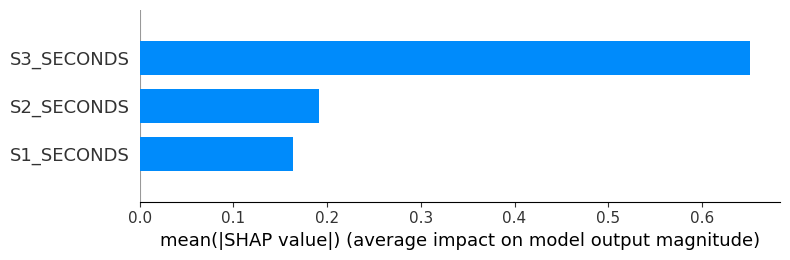

In [ ]:
import shap


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")

Based on the analysis, both the correlation and the SHAP feature importance results clearly indicate that Sector 3 (S3_SECONDS) is the most influential factor in determining the total lap time. The correlation between S3 and the total lap time is very high (0.92), and its SHAP importance is also dominant (0.86). Improving performance in Sector 3 will have the greatest impact on reducing overall lap times, while S1 and S2 play a secondary role. This suggests that teams and drivers should focus their efforts on optimizing Sector 3 to achieve the best possible results.

## Lap Improvement Prediction

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

df = ALL_SESSIONS.copy()

df['IMPROVED'] = (df['LAP_IMPROVEMENT'] > 0).astype(int)

features = [
    'LAP_NUMBER', 'S1_IMPROVEMENT', 'S2_IMPROVEMENT', 'S3_IMPROVEMENT',
    'TOP_SPEED', 'TEAM', 'MANUFACTURER', 'DRIVER_NAME', 'SESSION', 'CLASS'
]
df = df[features + ['IMPROVED']].dropna()

for col in ['TEAM', 'MANUFACTURER', 'DRIVER_NAME']:
    counts = df[col].value_counts()
    rare = counts[counts < 3].index
    df[col] = df[col].replace(rare, 'Other')

df_encoded = pd.get_dummies(df, columns=['TEAM', 'MANUFACTURER', 'DRIVER_NAME', 'SESSION', 'CLASS'])

X = df_encoded.drop('IMPROVED', axis=1)
y = df_encoded['IMPROVED']


scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


cv_scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
print(f"5-fold Cross-validated Accuracy: {cv_scores.mean():.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.90      1.00      0.95         9

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24

Confusion Matrix:
 [[14  1]
 [ 0  9]]
5-fold Cross-validated Accuracy: 0.9167


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

cv_scores = cross_val_score(logreg, X, y, cv=3, scoring='accuracy')
print(f"5-fold Cross-validated Accuracy: {cv_scores.mean():.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.89      0.89      0.89         9

    accuracy                           0.92        24
   macro avg       0.91      0.91      0.91        24
weighted avg       0.92      0.92      0.92        24

Confusion Matrix:
 [[14  1]
 [ 1  8]]
5-fold Cross-validated Accuracy: 0.8583


## Cluster-Based Analysis of Driving Styles by Sector

         S1_IMPROVEMENT  S2_IMPROVEMENT  S3_IMPROVEMENT
cluster                                                
0              0.016393        0.295082        0.016393
1              1.214286        0.035714        1.428571
2              1.709677        2.064516        1.774194


,S1_IMPROVEMENT,S2_IMPROVEMENT,S3_IMPROVEMENT
cluster,,,
0,0.02,0.30,0.02
1,1.21,0.04,1.43
2,1.71,2.06,1.77


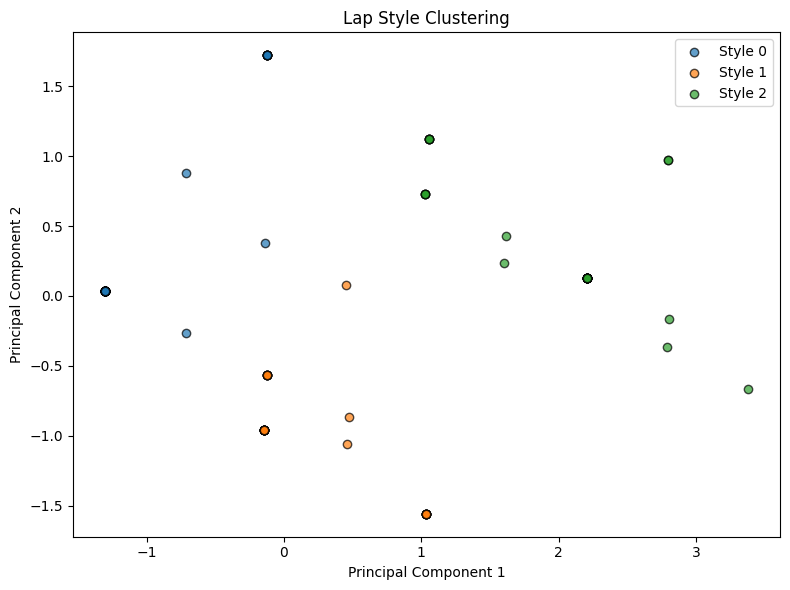

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


df = ALL_SESSIONS.copy()
X = df[["S1_IMPROVEMENT", "S2_IMPROVEMENT", "S3_IMPROVEMENT"]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["cluster"] = clusters

cluster_means = df.groupby("cluster")[["S1_IMPROVEMENT", "S2_IMPROVEMENT", "S3_IMPROVEMENT"]].mean()
styled_table = cluster_means.style.set_caption("Average Improvement by Cluster") \
    .background_gradient(cmap="Reds") \
    .format("{:.2f}") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('color', '#2d3a4a'), ('font-size', '18px'), ('font-weight', 'bold')]}
    ])
print(cluster_means) 
try:
    from IPython.display import display
    display(styled_table)
except ImportError:
    pass

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
for c in range(3):
    plt.scatter(X_pca[clusters==c,0], X_pca[clusters==c,1], label=f"Style {c}", alpha=0.7, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Lap Style Clustering")
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
style_dict = {
    0: "Conservative in S1 & S3, Attacks in S2",
    1: "Aggressive in S1 & S3, Conservative in S2",
    2: "Aggressive in all sectors"
}
df["style"] = df["cluster"].map(style_dict)
pilot_table = df[["DRIVER_NAME", "cluster", "style"]].drop_duplicates().tail(10)
print(pilot_table)

           DRIVER_NAME  cluster                                      style
95           Neel JANI        0     Conservative in S1 & S3, Attacks in S2
96            Yifei YE        0     Conservative in S1 & S3, Attacks in S2
99    Felipe DRUGOVICH        0     Conservative in S1 & S3, Attacks in S2
102          Neel JANI        1  Aggressive in S1 & S3, Conservative in S2
103     Dries VANTHOOR        0     Conservative in S1 & S3, Attacks in S2
105    Harry TINCKNELL        1  Aggressive in S1 & S3, Conservative in S2
108       Ricky TAYLOR        0     Conservative in S1 & S3, Attacks in S2
109  Stoffel VANDOORNE        0     Conservative in S1 & S3, Attacks in S2
111    Harry TINCKNELL        0     Conservative in S1 & S3, Attacks in S2
114   Jean-Eric VERGNE        2                  Aggressive in all sectors


The analysis of the clusters reveals distinct driving styles among the laps. Cluster 0 is characterized by drivers who are generally conservative in sectors 1 and 3, with average improvements of only 0.02 seconds in both, but tend to attack more in sector 2, achieving an average improvement of 0.30 seconds. Cluster 1 groups drivers who are aggressive in sectors 1 and 3, with average improvements of 1.21 and 1.43 seconds respectively, while being conservative in sector 2 (0.04 seconds). Finally, cluster 2 represents drivers who are aggressive throughout the entire lap, showing high average improvements in all sectors: 1.71 seconds in S1, 2.06 seconds in S2, and 1.77 seconds in S3. These patterns allow us to identify and compare the typical sector strategies of each group.